In [1]:
import multiprocessing 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import copy

import model_based_agent as mba 
import ensemble_mod_env as eme
import utils as ut
import tab_agents as tab

from datetime import datetime 

In [2]:
def one_learner(
    num_learners = 1,
    collection_eps = 1,
    gamma=0.25,
    epsilon=.5,
    alpha=.001,
    df_bound=-1,
    frac=1,
):

    qtabs = []
    # Start model environments and learners 
    dh = mba.DataHandler()
    dh.load_df('ensemble_testing.pkl')
    dh.df = dh.df[:df_bound]

    # Make new learner list based on newest data
    learners = mba.make_learner_list(num_learners, worm_pars={'num_models':1, 'frac':frac},
                            gamma=gamma, epsilon=epsilon, alpha=alpha)  
    return learners[0],dh,

def multiproc_sampled_models(
    num_learners = 10,
    collection_eps = 20,
    gamma=.25,
    epsilon=.5,
    alpha=.001,
    df_bound=-1,
    learn_limit=50000,
    frac=.5,
    init_df = 'ensemble_testing.pkl',
):
    '''
    Runs parallel learners and joins them afterward
    '''
    qtabs = []
    worm_agent = tab.Q_Alpha_Agent(gamma=gamma, epsilon=epsilon, alpha=alpha) # Agent doesn't learn
    # Start model environments and learners 
    dh = mba.DataHandler()
    dh.load_df(init_df)
    dh.df = dh.df[:df_bound]
    
    for loop in range(collection_eps):        
        # Make new learner list based on newest data
        learners = mba.make_learner_list(num_learners, worm_pars={'num_models':1, 'frac':frac},
                                gamma=gamma, epsilon=epsilon, alpha=alpha, 
                                q_checkpoint=worm_agent.Qtab,
                                )        
        
        # Start multiprocessing
        #manager = multiprocessing.Manager()
        #poison_queue = manager.Queue()
        pool = multiprocessing.Pool()
        
        # Run main functions: train agents and collect more data
        lea_outs = []
        print(loop)
        for lea in learners:
            lea_outs.append(pool.apply_async(lea.learn, [dh],{'learn_limit':learn_limit}))
        # Wait for them to finish
        pool.close()
        pool.join()
        for lea_out in lea_outs:
            if lea_out.successful() is False:
                raise Exception('One learner failed')
        
        # Combining learners from run
        worm_agent.Qtab = mba.combine_learners(lea_outs)
        qtabs.append(worm_agent.Qtab.reshape((12,12,2)))
    return qtabs

def eval_ep(lea,eval_steps=200000):
    obss = []
    acts = []
    rews = []
    for i in range(eval_steps):
        obs = lea.env._state
        acts.append(lea.agent.eval_act(obs))
        next_obs,rew,done,_ = lea.env.step(acts[-1])
        obss.append(next_obs)
        rews.append(rew)
    return obss,acts,rews

def plot_pol_and_qs(lea,vmin=-1,vmax=1):
    fig,ax = plt.subplots(1,3)
    fig.set_size_inches((12,2))
    img = ax[0].imshow(np.sign(lea.agent.Qtab[:,1].reshape(12,12)-lea.agent.Qtab[:,0].reshape(12,12)))
    fig.colorbar(img,ax=ax[0]);
    ax[0].set_title('Current policy')
    img = ax[1].imshow(lea.agent.Qtab[:,1].reshape(12,12),vmin=vmin,vmax=vmax)
    fig.colorbar(img,ax=ax[1]);
    ax[1].set_title('Light on Qtable')
    img = ax[2].imshow(lea.agent.Qtab[:,0].reshape(12,12),vmin=vmin,vmax=vmax)
    plt.colorbar(img,ax=ax[2])
    ax[2].set_title('Light off Qtable')

    [ax[i].axis('off') for i in range(3)];
    
def learn_ep(lea,l_steps=1000000,ep_len=100):
    obss = []
    acts = []
    rews = []
    for i in range(l_steps):
        if i%ep_len==0:
            lea.env.reset()
        obs = lea.env._state
        acts.append(lea.agent.act(obs))
        next_obs,rew,done,_ = lea.env.step(acts[-1])
        lea.agent.update(obs,acts[-1],next_obs,rew)
        obss.append(next_obs)
        rews.append(rew)
    return obss,acts,rews

# 0. Baselines for one model; make sure everything works

### With frac=.5 

In [7]:
learner,dh = one_learner(frac=.5)
learner.make_mod_and_env(dh,{'lambda':.1,'iters':10},)

On model 0
0.42796444558851676


#### Eval ep, random actions

In [13]:
obss,acts,rews = eval_ep(learner)
print(f'From init, eval episode reward is {np.mean(rews)}')

From init, eval episode reward is 0.4587291464022229


#### Eval ep, actions from reward mat

In [14]:
learner.agent.Qtab[:,0] = np.zeros(144)
learner.agent.Qtab[:,1] = np.sign(learner.modset.models[0]['reward_on'][:,:,0]-learner.modset.models[0]['reward_off'][:,:,0]).flatten()
obss,acts,rews = eval_ep(learner)

Just given reward matrices, no learning, eval ep is 0.558470689713088


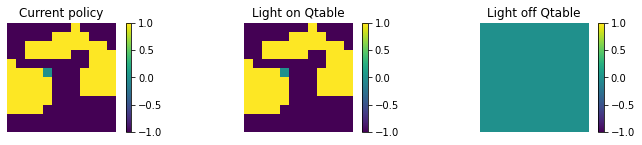

In [15]:
plot_pol_and_qs(learner)
print(f'Just given reward matrices, no learning, eval ep is {np.mean(rews)}')

#### Learning eps

Eval ep is 0.36948186721438353


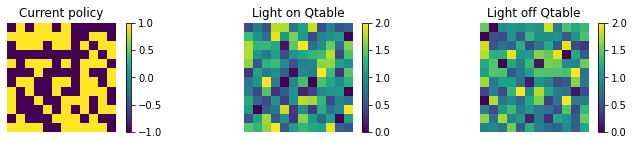

In [16]:
learner.agent.resetq()
obss,acts,rews = eval_ep(learner)
plot_pol_and_qs(learner,vmin=0,vmax=2)
print(f'Eval ep is {np.mean(rews)}')

1m learning steps, eval ep is 0.5471246276832945


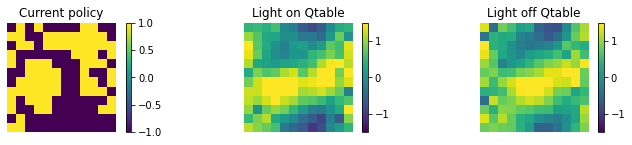

In [19]:
obss,acts,rews = learn_ep(learner)
obss,acts,rews = eval_ep(learner)
plot_pol_and_qs(learner,vmin=-1.5,vmax=1.5)
print(f'1m learning steps, eval ep is {np.mean(rews)}')

2m learning steps, eval ep is 0.5540818588522575


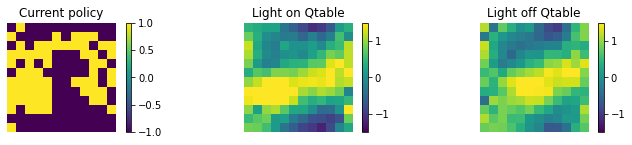

In [20]:
obss,acts,rews = learn_ep(learner)
obss,acts,rews = eval_ep(learner)
plot_pol_and_qs(learner,vmin=-1.5,vmax=1.5)
print(f'2m learning steps, eval ep is {np.mean(rews)}')

### With frac=1

In [21]:
learner,dh = one_learner(frac=1)
learner.make_mod_and_env(dh,{'lambda':.1,'iters':10},)

On model 0
0.7203703601051432


#### Eval ep, random actions

In [22]:
obss,acts,rews = eval_ep(learner)
print(f'From init, eval episode reward is {np.mean(rews)}')

From init, eval episode reward is 0.28846851678640983


#### Eval ep, actions from reward mat

In [28]:
learner.agent.Qtab[:,0] = np.zeros(144)
learner.agent.Qtab[:,1] = np.sign(learner.modset.models[0]['reward_on'][:,:,0]-learner.modset.models[0]['reward_off'][:,:,0]).flatten()
obss,acts,rews = eval_ep(learner)

Just given reward matrices, no learning, eval ep is 0.47506927769900786


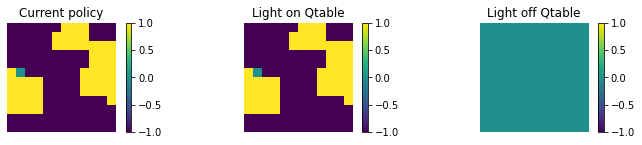

In [29]:
plot_pol_and_qs(learner)
print(f'Just given reward matrices, no learning, eval ep is {np.mean(rews)}')

#### Learning eps

Eval ep is 0.22827121359142657


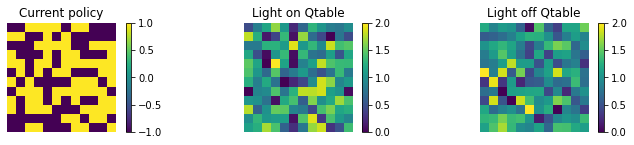

In [25]:
learner.agent.resetq()
obss,acts,rews = eval_ep(learner)
plot_pol_and_qs(learner,vmin=0,vmax=2)
print(f'Eval ep is {np.mean(rews)}')

1m learning steps, eval ep is 0.48698197326671566


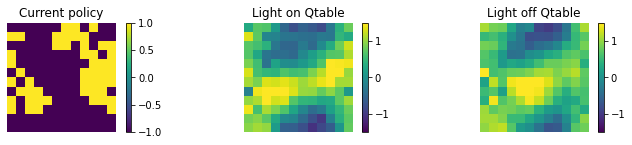

In [26]:
obss,acts,rews = learn_ep(learner)
obss,acts,rews = eval_ep(learner)
plot_pol_and_qs(learner,vmin=-1.5,vmax=1.5)
print(f'1m learning steps, eval ep is {np.mean(rews)}')

2m learning steps, eval ep is 0.47787516699914706


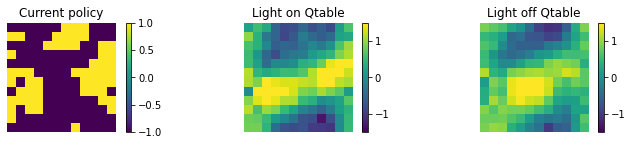

In [27]:
obss,acts,rews = learn_ep(learner)
obss,acts,rews = eval_ep(learner)
plot_pol_and_qs(learner,vmin=-1.5,vmax=1.5)
print(f'2m learning steps, eval ep is {np.mean(rews)}')

# 1. All data with partial models vs full models, averaged

In [5]:
qtabs = []
fracs = [.5,1]
for f in fracs:
    for i in range(5):
        qtabs.append(multiproc_sampled_models(
        num_learners = 10,
        collection_eps = 20,
        gamma=.25,
        epsilon=.5,
        alpha=.001,
        df_bound=-1,
        learn_limit=50000,
        frac=f, # Only variable that was changed between 1a and 1b
    ))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [6]:
scores = []
learner,dh = one_learner(frac=1)
learner.make_mod_and_env(dh,{'lambda':.1,'iters':10},)
for qtset in qtabs:
    for i,qt in enumerate(qtset):
        print(i)
        learner.agent.Qtab = qt.reshape((144,2))
        obss,acts,rews = eval_ep(learner)
        scores.append(np.mean(rews))

On model 0
0.7203703601051432
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### Plots for everything

In [23]:
scores_list = [[] for _ in range(10)]
for i in range(10):
    scores_list[i] = scores[i*20:i*20+20]
partials = np.mean(scores_list[:5],axis=0)
fulls = np.mean(scores_list[5:],axis=0)
partials_s = np.std(scores_list[:5],axis=0)
fulls_s = np.std(scores_list[5:],axis=0)

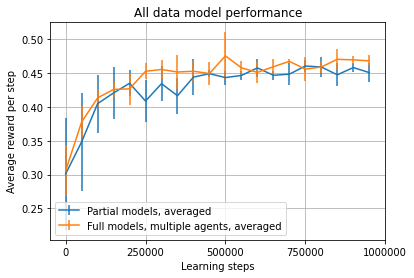

In [29]:
plt.errorbar(np.arange(20),partials,yerr=partials_s)
plt.errorbar(np.arange(20),fulls,yerr=fulls_s)
plt.ylabel('Average reward per step')
plt.xlabel('Learning steps')
plt.xticks(np.arange(0,21,5),np.arange(0,21,5)*50000);
plt.title('All data model performance')
plt.legend(['Partial models, averaged','Full models, multiple agents, averaged'])
plt.grid();

# 2. Partial data

In [3]:
def no_learn_performance(samples,frac):
    # Returns the performance of the eval episode using a policy based on differences
    # between reward_on and reward_off matrices.
    # Also returns the q matrix differences.
    learner, dh = one_learner(frac=frac)
    dh.df = dh.df[:samples]
    learner.make_mod_and_env(dh,{'lambda':.1,'iters':10})
    
    # Artificially set Q table
    learner.agent.Qtab[:,0] = np.zeros(144)
    q_diffs = learner.modset.models[0]['reward_on'][:,:,0]-learner.modset.models[0]['reward_off'][:,:,0]
    learner.agent.Qtab[:,1] = np.sign(q_diffs.flatten())
    
    obss,acts,rews = eval_ep(learner)
    perf = np.mean(rews)
    
    return perf, q_diffs

In [4]:
f_used = [.5,1]
samps_df = [5000,10000,15000,20000,25000,30000]

# First get reward matrix-based performance.
all_no_learn = []
all_no_learn_pol = []
half_no_learn = []
half_no_learn_pol = []
for s in samps_df:
    for f in f_used:
        perf,q_diffs = no_learn_performance(s,f)
        if f==.5:
            half_no_learn.append(perf)
            half_no_learn_pol.append(q_diffs) 
        elif f==1:
            all_no_learn.append(perf)
            all_no_learn_pol.append(q_diffs)
        else:
            print('Something went wrong')

On model 0
1.5034772970537442
On model 0
2.8137160120876232
On model 0
3.161402453440832
On model 0
1.4365161128204527
On model 0
1.346682532949642
On model 0


KeyboardInterrupt: 